# Fraud Detection ML Model Pipeline

This project aims to comprehensively cover the training of multiple models to achieve a good success rate in detecting fraudulent transactions on a PoS application, and testing said models to ultimately use the best one. This Colab notebook serves as the code part of the project.

Inspiration for the workflow is almost entirely taken from Google MLCC and inspired by searches and prompts to adapt to the problem at hand

# Dependencies

The succeeding block handles importing all dependencies for the project, and some basic configurations for said dependencies

In [ ]:
import pandas as pd
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


drive.mount("/content/drive")

# The following lines improve the readability of the pandas outputs, idea from Google MLCC.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

Mounted at /content/drive


#Importing a dataset

The succeeding code handles importing a dataset relevant to the fraudulent transaction detection ML model.

The dataset is from a competition from Kaggle,
 [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data)

In [ ]:
finData_raw = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv')
identityData_raw = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv')
print(finData_raw.head())
print(identityData_raw.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

Clearly, the dataset contains a lot of data, but most of it is not useful from our perspective as we would not be able to collect that data and run the model in deployment on all those data points if we don't even know what the datapoints are, as the features are anonymized.

The below code aims to refine the dataset into a usable dataframe, by picking out the features that are not anonymized and may actually be useful in pattern detection.

In [ ]:
finData = finData_raw[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card4', 'card6','P_emaildomain', 'R_emaildomain']]
identityData = identityData_raw[['TransactionID', 'id_30', 'id_31','DeviceType', 'DeviceInfo']]


finData.describe()


,TransactionID,isFraud,TransactionDT,TransactionAmt
count,590540.0,590540.0,590540.0,590540.0
mean,3282269.5,0.0,7372311.3,135.0
std,170474.4,0.2,4617223.6,239.2
min,2987000.0,0.0,86400.0,0.3
25%,3134634.8,0.0,3027057.8,43.3
50%,3282269.5,0.0,7306527.5,68.8
75%,3429904.2,0.0,11246620.0,125.0
max,3577539.0,1.0,15811131.0,31937.4


The Transaction Amounts are clearly very varied, there is need for much further data analysis.

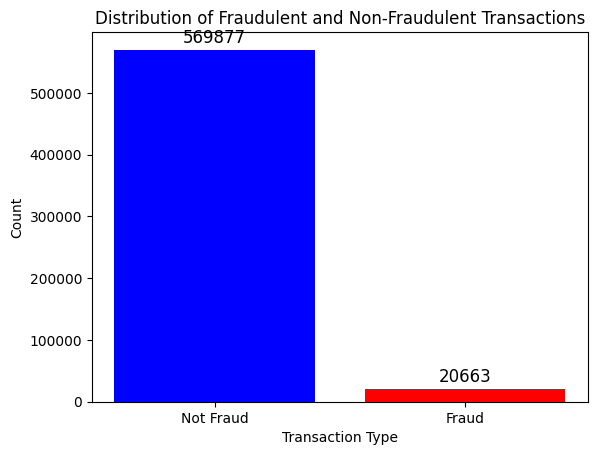

In [ ]:
#Visualizing the imbalance in the dataset

fraud_counts = finData['isFraud'].value_counts()

# Ploting the histogram
plt.bar(fraud_counts.index, fraud_counts.values, color=['blue', 'red'], tick_label=['Not Fraud', 'Fraud'])

for i, count in enumerate(fraud_counts.values):
    plt.text(i, count + 0.02 * max(fraud_counts.values), str(count), ha='center', fontsize=12, color='black')

plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

The ratio of not fraud to fraud transactions is roughly 27:1, there will be a need of downsampling and downsampling and upweighting it to a more reasonable ratio

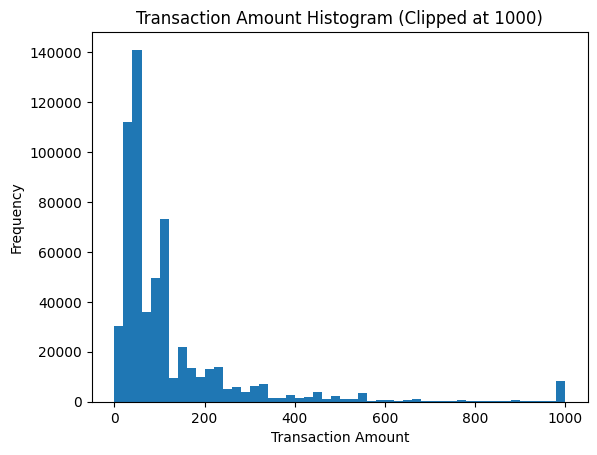

In [ ]:
plt.hist(finData['TransactionAmt'].clip(upper=1000), bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Transaction Amount Histogram (Clipped at 1000)')
plt.show()

Clipping at about 400 would be better to not bias the model too much towards bigger transactions since they are much rarer

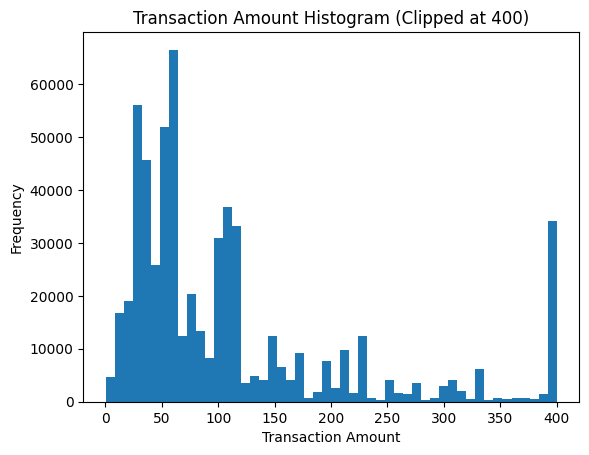

In [ ]:

plt.hist(finData['TransactionAmt'].clip(upper=400), bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Transaction Amount Histogram (Clipped at 400)')
plt.show()

<ipython-input-7-fc04306fc88a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['amount_clipped'] = fraud_transactions['TransactionAmt'].clip(upper=400)


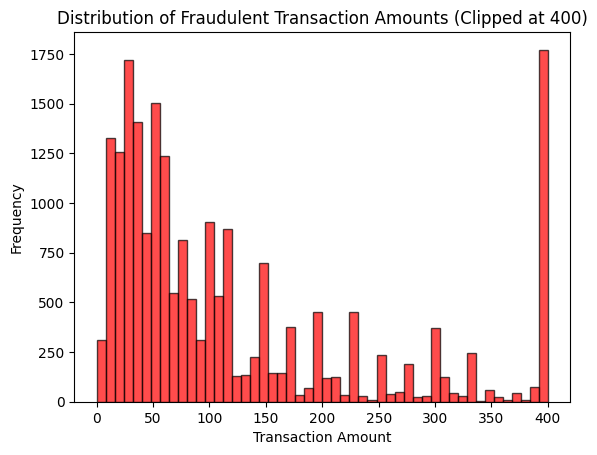

In [ ]:
# filtering for fraud transactions
fraud_transactions = finData[finData['isFraud'] == 1]

fraud_transactions['amount_clipped'] = fraud_transactions['TransactionAmt'].clip(upper=400)

# plotting the histogram
plt.hist(fraud_transactions['amount_clipped'], bins=50, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Fraudulent Transaction Amounts (Clipped at 400)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

IT appears there is more likelihood of the transaction being fraudulent if the amount is too low or too high, that is where the data deviates, also seemingly at nice round numbers

#Data Preprocessing and Feature Engineering

Firstly, to use the data in the identity file, we need to keep only the ones for which we have identity data, but also observe if this results in further imbalancing of the dataset or not.

In [ ]:
# Merging the two dataframes based on 'TransactionID'
merged_df = pd.merge(finData, identityData, on='TransactionID', how='inner')

print(merged_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt       card4   card6  \
0        2987004        0          86506            50.0  mastercard  credit   
1        2987008        0          86535            15.0        visa   debit   
2        2987010        0          86549            75.9  mastercard  credit   
3        2987011        0          86555            16.5  mastercard   debit   
4        2987016        0          86620            30.0        visa   debit   

   P_emaildomain R_emaildomain             id_30                id_31  \
0      gmail.com           NaN       Android 7.0  samsung browser 6.2   
1  anonymous.com           NaN        iOS 11.1.2   mobile safari 11.0   
2      gmail.com     gmail.com               NaN          chrome 62.0   
3    hotmail.com   hotmail.com               NaN          chrome 62.0   
4        aol.com           NaN  Mac OS X 10_11_6          chrome 62.0   

  DeviceType                     DeviceInfo  
0     mobile  SAMSUNG SM-G892A Bui

Plotting Not Fraud vs Fraud again

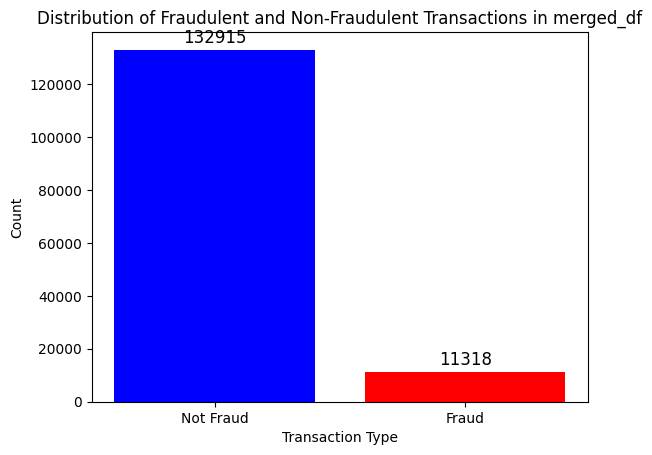

In [ ]:
mergedFraud_counts = merged_df['isFraud'].value_counts()

# Ploting the histogram
plt.bar(mergedFraud_counts.index, mergedFraud_counts.values, color=['blue', 'red'], tick_label=['Not Fraud', 'Fraud'])

for i, count in enumerate(mergedFraud_counts.values):
    plt.text(i, count + 0.02 * max(mergedFraud_counts.values), str(count), ha='center', fontsize=12, color='black')

plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions in merged_df')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

This already reduces the imbalance to 11:1 while still having plenty of examples for both scenarios.

Next, it is important to deal with missing values.

In [ ]:
# Calculate the number of missing values per column
missing_counts = merged_df.isnull().sum()

print("Missing values per feature:")
print(missing_counts)

# Calculating the total number of rows with any missing data
rows_with_missing_data = merged_df.isnull().any(axis=1).sum()
print("\nTotal number of rows with any missing data:", rows_with_missing_data)

Missing values per feature:
TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
card4               184
                  ...  
R_emaildomain     13150
id_30             66668
id_31              3951
DeviceType         3423
DeviceInfo        25567
Length: 12, dtype: int64

Total number of rows with any missing data: 88535


Clearly, the number of rows with missing data is way too high to all be removed.

R_emaildomain is not that important of a datapoint, it can be neglected.

card4 has small enough number of values to be replaced by the most occurring card4 value

id_30 and DeviceInfo is rendered unusable with almost half the rows missing, will need to be neglected.

id_31 and DeviceType can be filled with the most occurring ones, small enough number of values.

In [ ]:
# Removing the unusable features

inter_df = merged_df.drop(columns=['R_emaildomain', 'id_30', 'DeviceInfo'])

In [ ]:
# Filling missing values with the most occurring value

inter_df['card4'] = inter_df['card4'].fillna(inter_df['card4'].mode()[0])
inter_df['id_31'] = inter_df['id_31'].fillna(inter_df['id_31'].mode()[0])
inter_df['DeviceType'] = inter_df['DeviceType'].fillna(inter_df['DeviceType'].mode()[0])
inter_df['P_emaildomain'] = inter_df['P_emaildomain'].fillna(inter_df['P_emaildomain'].mode()[0])
inter_df['card6'] = inter_df['card6'].fillna(inter_df['card6'].mode()[0])

In [ ]:
#Confirming that no values are missing

missing_counts = inter_df.isnull().sum()

print("Missing values per feature:")
print(missing_counts)

rows_with_missing_data = inter_df.isnull().any(axis=1).sum()
print("\nTotal number of rows with any missing data:", rows_with_missing_data)

Missing values per feature:
TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
card4             0
card6             0
P_emaildomain     0
id_31             0
DeviceType        0
dtype: int64

Total number of rows with any missing data: 0


In [ ]:
print(inter_df)

        TransactionID  isFraud  TransactionDT  TransactionAmt       card4  \
0             2987004        0          86506            50.0  mastercard   
1             2987008        0          86535            15.0        visa   
2             2987010        0          86549            75.9  mastercard   
3             2987011        0          86555            16.5  mastercard   
4             2987016        0          86620            30.0        visa   
...               ...      ...            ...             ...         ...   
144228        3577521        0       15810802            48.9  mastercard   
144229        3577526        1       15810876           250.0        visa   
144230        3577529        0       15810912            73.8  mastercard   
144231        3577531        0       15810935           400.0        visa   
144232        3577534        0       15811030            67.5  mastercard   

         card6  P_emaildomain                    id_31 DeviceType  
0      

Let's check how many distinct values are there for card4, card6, P_emaildomain, id_31, DeviceType.

In [ ]:
# Printing the number of distinct values for specified columns
for col in ['card4', 'card6', 'P_emaildomain', 'id_31', 'DeviceType']:
    print(f'Distinct values for {col}: {inter_df[col].nunique()}')

Distinct values for card4: 4
Distinct values for card6: 3
Distinct values for P_emaildomain: 59
Distinct values for id_31: 130
Distinct values for DeviceType: 2


In [ ]:
# Printing unique card 4, card6, DeviceType values
print(inter_df['card4'].unique(), inter_df['card6'].unique(), inter_df['DeviceType'].unique())

['mastercard' 'visa' 'american express' 'discover'] ['credit' 'debit' 'charge card'] ['mobile' 'desktop']


These values can be dealt with using one-hot encoding

In [ ]:
# One-hot encoding 'card4', 'card6', and 'DeviceType'
inter_df = pd.get_dummies(inter_df, columns=['card4', 'card6', 'DeviceType'])

print(inter_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt  P_emaildomain  \
0        2987004        0          86506            50.0      gmail.com   
1        2987008        0          86535            15.0  anonymous.com   
2        2987010        0          86549            75.9      gmail.com   
3        2987011        0          86555            16.5    hotmail.com   
4        2987016        0          86620            30.0        aol.com   

                 id_31  card4_american express  card4_discover  \
0  samsung browser 6.2                   False           False   
1   mobile safari 11.0                   False           False   
2          chrome 62.0                   False           False   
3          chrome 62.0                   False           False   
4          chrome 62.0                   False           False   

   card4_mastercard  card4_visa  card6_charge card  card6_credit  card6_debit  \
0              True       False              False          True       

In [ ]:
print(inter_df)

        TransactionID  isFraud  TransactionDT  TransactionAmt  P_emaildomain  \
0             2987004        0          86506            50.0      gmail.com   
1             2987008        0          86535            15.0  anonymous.com   
2             2987010        0          86549            75.9      gmail.com   
3             2987011        0          86555            16.5    hotmail.com   
4             2987016        0          86620            30.0        aol.com   
...               ...      ...            ...             ...            ...   
144228        3577521        0       15810802            48.9       yahoo.fr   
144229        3577526        1       15810876           250.0      gmail.com   
144230        3577529        0       15810912            73.8      gmail.com   
144231        3577531        0       15810935           400.0      gmail.com   
144232        3577534        0       15811030            67.5      gmail.com   

                          id_31  card4_

In [ ]:
encoded_columns = inter_df.select_dtypes(include=['bool']).columns
inter_df[encoded_columns] = inter_df[encoded_columns].astype(int)

In [ ]:
print(inter_df)

        TransactionID  isFraud  TransactionDT  TransactionAmt  P_emaildomain  \
0             2987004        0          86506            50.0      gmail.com   
1             2987008        0          86535            15.0  anonymous.com   
2             2987010        0          86549            75.9      gmail.com   
3             2987011        0          86555            16.5    hotmail.com   
4             2987016        0          86620            30.0        aol.com   
...               ...      ...            ...             ...            ...   
144228        3577521        0       15810802            48.9       yahoo.fr   
144229        3577526        1       15810876           250.0      gmail.com   
144230        3577529        0       15810912            73.8      gmail.com   
144231        3577531        0       15810935           400.0      gmail.com   
144232        3577534        0       15811030            67.5      gmail.com   

                          id_31  card4_

id_31, P_emaildomain can be dealt with the sparse one hot encoding representation

In [ ]:
# Creating a OneHotEncoder object with sparse=True
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

enc.fit(inter_df[['id_31', 'P_emaildomain']])

encoded_data = enc.transform(inter_df[['id_31', 'P_emaildomain']])

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data)

inter_df = pd.concat([inter_df, encoded_df], axis=1)

# Dropping the original 'id_31' and 'P_emaildomain' columns
inter_df = inter_df.drop(['id_31', 'P_emaildomain'], axis=1)

print(inter_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt  \
0        2987004        0          86506            50.0   
1        2987008        0          86535            15.0   
2        2987010        0          86549            75.9   
3        2987011        0          86555            16.5   
4        2987016        0          86620            30.0   

   card4_american express  card4_discover  card4_mastercard  card4_visa  \
0                       0               0                 1           0   
1                       0               0                 0           1   
2                       0               0                 1           0   
3                       0               0                 1           0   
4                       0               0                 0           1   

   card6_charge card  card6_credit  ...  179  180  181  182  183  184  185  \
0                  0             1  ...    0    0    0    0    0    0    0   
1                  0            

TransactionDT and TransactionID is not of much use from a training perspective, dropping it in the following code section

In [ ]:
inter_df = inter_df.drop(columns=['TransactionDT', 'TransactionID'])
print(inter_df.head())

   isFraud  TransactionAmt  card4_american express  card4_discover  \
0        0            50.0                       0               0   
1        0            15.0                       0               0   
2        0            75.9                       0               0   
3        0            16.5                       0               0   
4        0            30.0                       0               0   

   card4_mastercard  card4_visa  card6_charge card  card6_credit  card6_debit  \
0                 1           0                  0             1            0   
1                 0           1                  0             0            1   
2                 1           0                  0             1            0   
3                 1           0                  0             0            1   
4                 0           1                  0             0            1   

   DeviceType_desktop  ...  179  180  181  182  183  184  185  186  187  188  
0            

As a final step, we need to normalize TransactionAmt using Z-score scaling, after clipping it at 400

In [ ]:
# Clipping TransactionAmt at 400 and scaling it
inter_df['TransactionAmt'] = inter_df['TransactionAmt'].clip(upper=400)
scaler = StandardScaler()

inter_df['TransactionAmt'] = scaler.fit_transform(inter_df[['TransactionAmt']])

print(inter_df.head())

   isFraud  TransactionAmt  card4_american express  card4_discover  \
0        0            -0.4                       0               0   
1        0            -0.8                       0               0   
2        0            -0.1                       0               0   
3        0            -0.8                       0               0   
4        0            -0.6                       0               0   

   card4_mastercard  card4_visa  card6_charge card  card6_credit  card6_debit  \
0                 1           0                  0             1            0   
1                 0           1                  0             0            1   
2                 1           0                  0             1            0   
3                 1           0                  0             0            1   
4                 0           1                  0             0            1   

   DeviceType_desktop  ...  179  180  181  182  183  184  185  186  187  188  
0            

In [ ]:
import json
import joblib
from google.colab import files

joblib.dump(enc, 'encoder.joblib')

categorical_features = ['id_31', 'P_emaildomain']
categories = enc.categories_
feature_names = enc.get_feature_names_out(categorical_features)


encoder_info = {
    'categories': [list(cat) for cat in categories],
    'feature_names': list(feature_names)
}
with open('encoder_info.json', 'w') as f:
    json.dump(encoder_info, f)

# Download the files
files.download('encoder.joblib')
files.download('encoder_info.json')

joblib.dump(scaler, 'zscore_scaler.joblib')

files.download('zscore_scaler.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(merged_df[merged_df['isFraud'] == 1].head())

    TransactionID  isFraud  TransactionDT  TransactionAmt       card4   card6  \
52        2987240        1          90193            37.1        visa  credit   
53        2987243        1          90246            37.1        visa  credit   
54        2987245        1          90295            37.1        visa  credit   
69        2987288        1          90986           155.5        visa  credit   
86        2987367        1          92350           225.0  mastercard  credit   

   P_emaildomain R_emaildomain       id_30                    id_31  \
52   hotmail.com   hotmail.com         NaN  chrome 54.0 for android   
53   hotmail.com   hotmail.com         NaN  chrome 54.0 for android   
54   hotmail.com   hotmail.com         NaN  chrome 54.0 for android   
69   outlook.com   outlook.com         NaN      chrome 62.0 for ios   
86     gmail.com     gmail.com  Windows 10                  firefox   

   DeviceType                 DeviceInfo  
52     mobile  Redmi Note 4 Build/MMB29M  


#Addressing Class Imbalance

We have seen before how the number of non fraudulent to fraudulent transactions is 11:1. Let's make it 3:1 by using imbalanced-learn

In [ ]:
X = inter_df.drop('isFraud', axis=1)
y = inter_df['isFraud']

# Converting all column names to strings
X.columns = X.columns.astype(str)

# Combining RandomUnderSampler and RandomOverSampler
over = RandomOverSampler(sampling_strategy=0.33) # sampling_strategy=0.33 for 3:1 ratio
under = RandomUnderSampler(sampling_strategy=0.33) # sampling_strategy=0.33 for 3:1 ratio
X_over, y_over = over.fit_resample(X, y)
X_resampled, y_resampled = under.fit_resample(X_over, y_over)

# Creating a new DataFrame with the resampled data
inter_df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
inter_df_resampled['isFraud'] = y_resampled

print(inter_df_resampled['isFraud'].value_counts())

isFraud
0    132912
1     43861
Name: count, dtype: int64


#Training using Logistic Regression and Evaluation

Below is the code for training and evaluating the model using Logistic Regression. After trying several activation functions, I found sigmoid to be best

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6622 - loss: 0.6943 - val_accuracy: 0.7622 - val_loss: 0.5775
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7673 - loss: 0.5277 - val_accuracy: 0.7712 - val_loss: 0.5653
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7705 - loss: 0.5116 - val_accuracy: 0.7718 - val_loss: 0.5661
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7714 - loss: 0.4938 - val_accuracy: 0.7728 - val_loss: 0.5667
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7731 - loss: 0.4944 - val_accuracy: 0.7731 - val_loss: 0.5665
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7726 - loss: 0.5042 - val_accuracy: 0.7715 - val_loss: 0.5654
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7723 - loss: 0.4913 - val_accuracy: 0.7718 - val_loss: 0.5645
Epoch 8/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7719 - loss: 0.4974 - val_accuracy: 0.

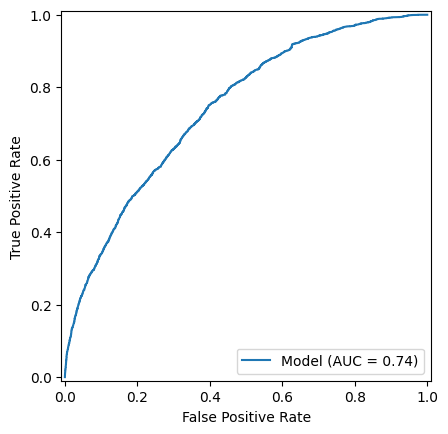

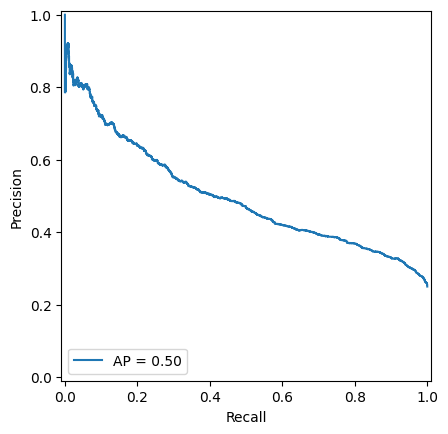

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve # Importing roc_curve
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Assuming 'inter_df_resampled' is your preprocessed DataFrame
X = inter_df_resampled.drop('isFraud', axis=1)
y = inter_df_resampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building the Logistic Regression model using Keras
model = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=0.3)

# Evaluate the model
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.65).astype(int)  # Convert probabilities to class labels

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Computing ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Calculating fpr and tpr using roc_curve before plotting
fpr, tpr, _ = roc_curve(y_test, y_pred_prob) # Calculating fpr and tpr

# Plotting ROC Curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Model").plot()

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc}")

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc).plot()

As can be observed, the model does a decent job at finding fraud transactions, but only finds about half the fraudulent transactions even after much tuning. There is clearly room to improve.

#Random Forest and Evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy: 0.9289775137887145
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     26517
           1       0.85      0.86      0.86      8838

    accuracy                           0.93     35355
   macro avg       0.90      0.91      0.91     35355
weighted avg       0.93      0.93      0.93     35355

ROC AUC Score: 0.9707479302773508


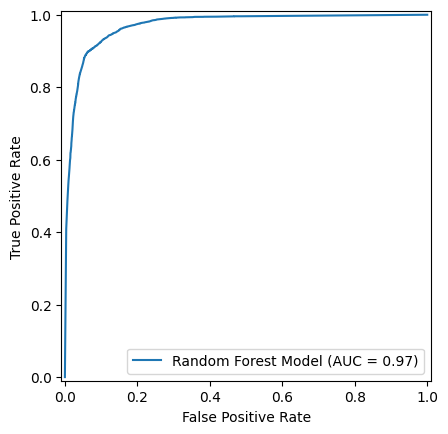

Precision-Recall AUC Score: 0.9219915236431917


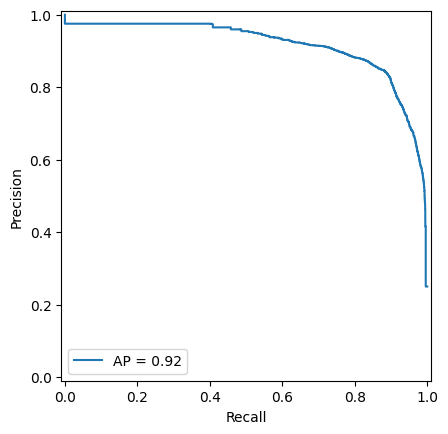

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'inter_df_resampled' is your preprocessed DataFrame
X = inter_df_resampled.drop('isFraud', axis=1)
y = inter_df_resampled['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=47) # You can tune hyperparameters
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1] # Probability of class 1 (fraud)
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Calculate fpr and tpr using roc_curve before plotting
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest Model").plot()
plt.show()


# Compute Precision-Recall AUC score
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc}")

# Plot Precision-Recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc).plot()
plt.show()

As is clear, this model is ballin'

In [ ]:
import joblib

# Save the model to a .joblib file
joblib.dump(rf_classifier, 'rf_classifier.joblib')

# Download the file
files.download('rf_classifier.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#XGBoost and Evaluation

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Accuracy: 0.8994484514212983
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     26517
           1       0.82      0.77      0.79      8838

    accuracy                           0.90     35355
   macro avg       0.87      0.86      0.86     35355
weighted avg       0.90      0.90      0.90     35355

ROC AUC Score: 0.9560467931936698


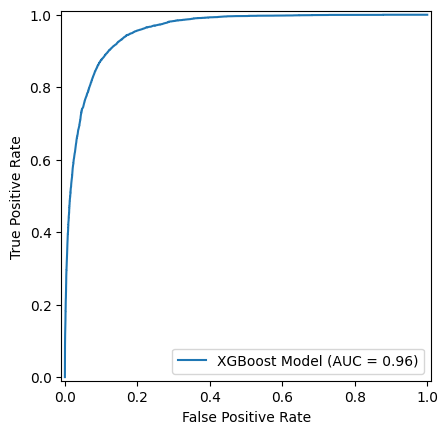

Precision-Recall AUC Score: 0.8784116629604586


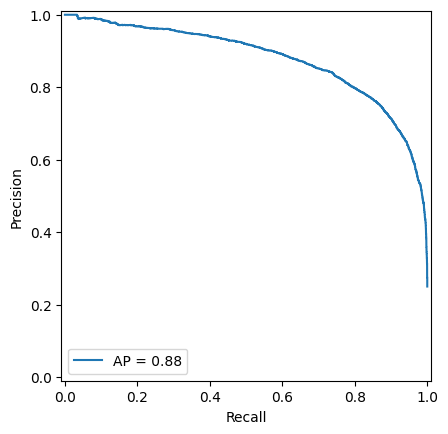

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Assuming 'inter_df_resampled' is your preprocessed DataFrame
X = inter_df_resampled.drop('isFraud', axis=1)
y = inter_df_resampled['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, learning_rate = 0.08, n_estimators = 800, max_depth = 15, subsample = 0.7 )  # You can tune hyperparameters here
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Calculate fpr and tpr using roc_curve before plotting
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="XGBoost Model").plot()
plt.show()

# Compute Precision-Recall AUC score
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc}")

# Plot Precision-Recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc).plot()
plt.show()

Considering the evaluation metrics, the above XGBoost model is decent, and after much tuning, a decent middleground has been achieved.

#Neural Networks and Evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer

Epoch 1/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7445 - loss: 0.7055 - val_accuracy: 0.7483 - val_loss: 0.5250
Epoch 2/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7520 - loss: 0.5324 - val_accuracy: 0.7483 - val_loss: 0.5202
Epoch 3/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7529 - loss: 0.5262 - val_accuracy: 0.7483 - val_loss: 0.5218
Epoch 4/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7500 - loss: 0.5294 - val_accuracy: 0.7483 - val_loss: 0.5177
Epoch 5/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7515 - loss: 0.5266 - val_accuracy: 0.7483 - val_loss: 0.5138
Epoch 6/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7528 - loss: 0.5250 - val_accuracy: 0.7483 - val_loss: 0.5181
Epoch 7/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7518 - loss: 0.5239 - val_accuracy: 0.7483 - val_loss: 0.5120
Epoch 8/50
7734/7734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7541 - loss: 0

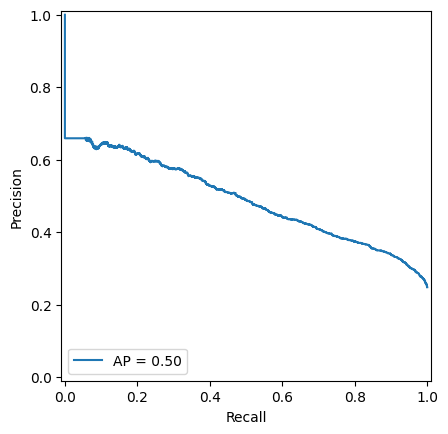

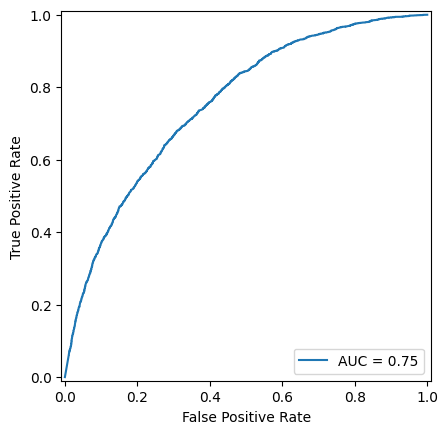

In [ ]:
X = inter_df_resampled.drop('isFraud', axis=1)
y = inter_df_resampled['isFraud']

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),  # Add dropout for regularization
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights, validation split, and early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate PR AUC score
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Plot Precision-Recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc).plot()
plt.show()


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.show()

After much tweaking, the model doesn't ever get an accuracy of more than ~80%, except that it was 96% once when the validation accuracy is like 4-5% clearly indicating overfitting. The neural network is not even better than the logistic regression model.

#Interpretability

Tried to implement SHAP analysis, but it was just taking way too much time.

In [ ]:
import shap

# Sampling 40 instances from X_test for faster SHAP analysis
X_test_sampled = X_test.sample(n=40, random_state=42)

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_sampled)

# Summary plot
shap.summary_plot(shap_values, X_test_sampled, plot_type="bar")

# Force plot for individual predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_sampled.iloc[0,:])